In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from dateutil.parser import parse

In [2]:
data = pd.read_csv('dhanuka_daily.csv')
data.tail()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
2340,2020-12-09,DHANUKA,EQ,751.00,754.8,758.0,734.0,743.0,739.20,744.79,59249,4.412832e+12,3897,42971,0.7253
2341,2020-12-10,DHANUKA,EQ,739.20,740.0,763.1,728.5,761.6,759.85,751.76,73428,5.520032e+12,4986,39533,0.5384
2342,2020-12-11,DHANUKA,EQ,759.85,765.0,769.0,738.0,745.7,745.60,753.31,42964,3.236536e+12,2976,23686,0.5513
2343,2020-12-14,DHANUKA,EQ,745.60,745.7,753.9,742.0,750.6,746.95,746.34,38928,2.905346e+12,3230,27928,0.7174
2344,2020-12-15,DHANUKA,EQ,746.95,748.0,750.0,728.5,736.0,733.85,736.00,43225,3.181369e+12,3532,30507,0.7058


In [3]:
data = data[["Date", "Open", "High", "Low", "Close","Volume"]]
data.head()

,Date,Open,High,Low,Close,Volume
0,2011-06-29,92.6,96.95,87.00,89.05,121987
1,2011-06-30,90.7,90.70,87.00,88.60,37830
2,2011-07-01,83.0,90.00,83.00,89.00,48253
3,2011-07-04,91.0,91.00,88.00,89.00,40203
4,2011-07-05,88.8,90.85,88.25,88.70,40502


In [4]:
data = data.drop('Date', axis = 1)
data = data.drop(0, axis = 0)
data.head()

,Open,High,Low,Close,Volume
1,90.7,90.70,87.00,88.60,37830
2,83.0,90.00,83.00,89.00,48253
3,91.0,91.00,88.00,89.00,40203
4,88.8,90.85,88.25,88.70,40502
5,87.3,93.50,87.30,93.15,112367


In [5]:
history_points = 30

In [6]:
data_normaliser = preprocessing.MinMaxScaler()
data_normalised = data_normaliser.fit_transform(data)
data_normalised

array([[0.01262055, 0.00961088, 0.0108085 , 0.00883213, 0.02542001],
       [0.00345279, 0.00879044, 0.0059233 , 0.00930954, 0.03242842],
       [0.01297774, 0.00996249, 0.0120298 , 0.00930954, 0.02701561],
       ...,
       [0.81545422, 0.80461791, 0.80587445, 0.79298204, 0.02887211],
       [0.79247529, 0.78691983, 0.81075965, 0.7945933 , 0.02615831],
       [0.79521372, 0.7823488 , 0.79427211, 0.77895805, 0.0290476 ]])

In [7]:
data_normalised[:,0][30]

0.024288605786403156

In [8]:
ohlcv_histories_normalised = np.array([data_normalised[i:i+history_points].copy() for i in range(len(data_normalised)- history_points)])
ohlcv_histories_normalised.shape

(2314, 30, 5)

In [9]:
next_day_open_values_normalised = np.array([data_normalised[:,0][i+history_points].copy() for i in range(len(data_normalised)- history_points)])
next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised,-1)
next_day_open_values_normalised.shape

(2314, 1)

In [10]:
next_day_open_values = np.array([data.iloc[:,1][i+history_points].copy() for i in range(len(data)-history_points)])
next_day_open_values = np.expand_dims(next_day_open_values,-1)
next_day_open_values.shape

(2314, 1)

In [11]:
y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit(next_day_open_values)

MinMaxScaler()

In [12]:
assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0]

In [13]:
history_points = 84

In [14]:
def csv_to_dataset(csv_path):
    data = pd.read_csv(csv_path)
    data = data.drop('Date', axis = 1)
    data = data.drop(0,axis = 0)
    data = data[["Open", "High", "Low", "Close","Volume"]]
    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)
    
    #using last open high low close volume data points, to predict the next open value
    ohlcv_histories_normalised = np.array([data_normalised[i:i+history_points].copy() for i in range(len(data_normalised)- history_points)])
    next_day_open_values_normalised = np.array([data_normalised[:,0][i+history_points].copy() for i in range(len(data_normalised)-history_points)])
    next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)
    
    next_day_open_values = np.array([data.iloc[:,0][i+history_points].copy() for i in range(len(data)- history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values,-1)
    
    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_open_values)
    
    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0]
    return ohlcv_histories_normalised, next_day_open_values_normalised, next_day_open_values, y_normaliser

In [15]:
ohlcv_histories, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset('dhanuka_daily.csv')
ohlcv_histories.shape

(2260, 84, 5)

In [16]:
test_split = 0.95
n = int(ohlcv_histories.shape[0]*test_split)

ohlcv_train = ohlcv_histories[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]
print(y_train.shape)
print(y_test.shape)

(2147, 1)
(113, 1)


In [17]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense,Dropout,LSTM,Input,Activation,concatenate
from keras import optimizers
import numpy as np
tf.random.set_seed(4)

lstm_input = Input(shape = (history_points,5), name = 'lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name = 'lstm_dropout_0')(x)
x = Dense(128, name = 'dense_0')(x)
x = Activation('sigmoid', name = 'sigmoid_0')(x)
x = Dense(1, name = 'dense_1')(x)
output = Activation('linear', name = 'linear_output')(x)
model = Model(inputs = lstm_input, outputs = output)

adam = optimizers.Adam(lr = 0.0005)

model.compile(optimizer = adam, loss='mse')

from keras.utils import plot_model
plot_model(model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [18]:
model.fit(x = ohlcv_train, y=y_train, batch_size = 32, epochs = 50, shuffle = True, validation_split = 0.1)
evaluation = model.evaluate(ohlcv_test, y_test)

Epoch 1/50
61/61 [==============================] - 2s 37ms/step - loss: 0.1895 - val_loss: 0.0045
Epoch 2/50
61/61 [==============================] - 2s 28ms/step - loss: 0.0050 - val_loss: 0.0023
Epoch 3/50
61/61 [==============================] - 2s 28ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 4/50
61/61 [==============================] - 2s 28ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 5/50
61/61 [==============================] - 2s 29ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 6/50
61/61 [==============================] - 2s 29ms/step - loss: 0.0023 - val_loss: 0.0016ETA: 0s - 
Epoch 7/50
61/61 [==============================] - 2s 29ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 8/50
61/61 [==============================] - 2s 29ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 9/50
61/61 [==============================] - 2s 29ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 10/50
61/61 [==============================] - 2s 29ms/step - loss: 0.0019 - val_loss: 0.0014

In [19]:
print(evaluation)

0.0013020547339692712


In [20]:
y_test_predicted = model.predict(ohlcv_test)

y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

#Predictions for the whole dataset
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape

In [21]:
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse/(np.max(unscaled_y_test)-np.min(unscaled_y_test))*100
print(scaled_mse)

320.6783938877816


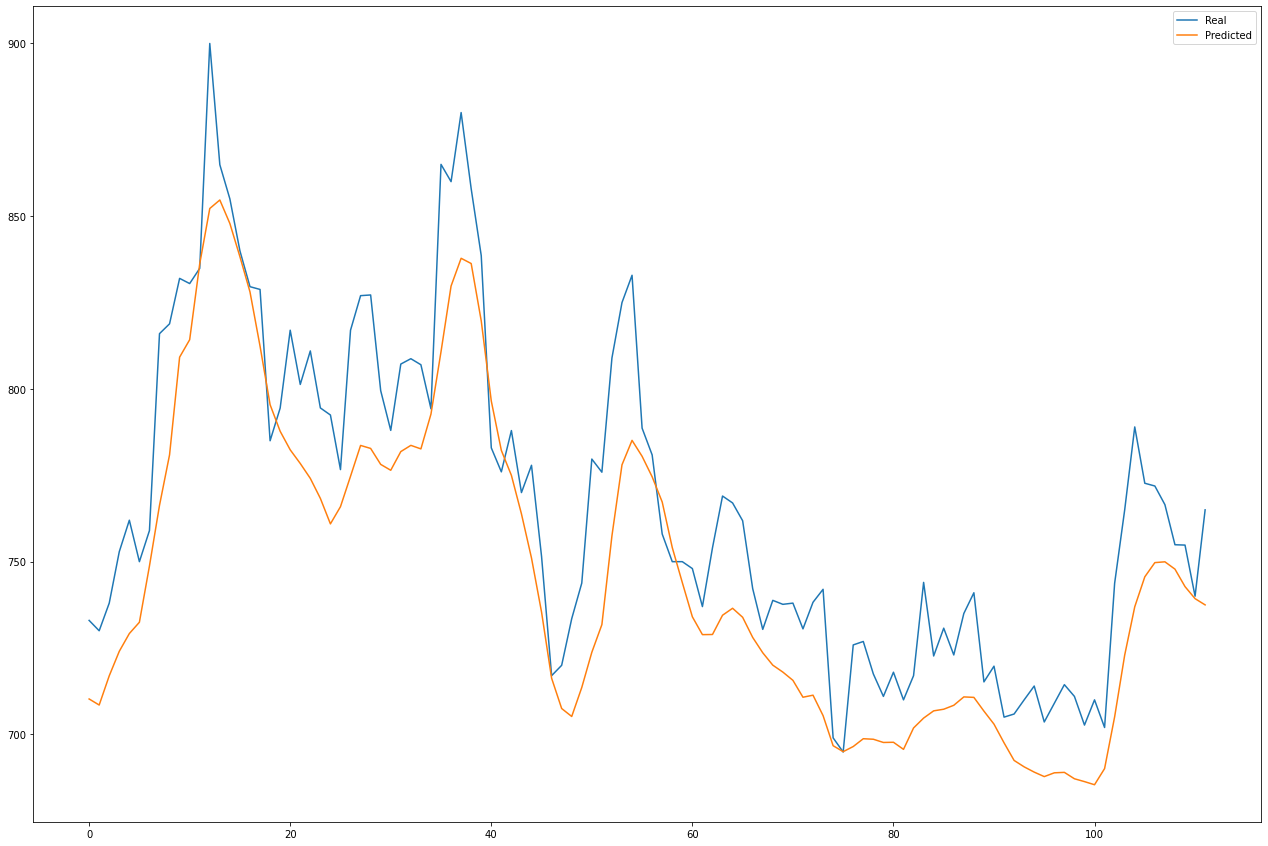

In [22]:
import matplotlib.pyplot as plt
plt.gcf().set_size_inches(22,15, forward = True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label = 'predicted')

plt.legend(['Real','Predicted'])
plt.show()

In [23]:
def csv_to_dataset(csv_path):
    data = pd.read_csv(csv_path)
    data = data.drop('Date', axis = 1)
    data = data.drop(0,axis = 0)
    data = data[["Open", "High", "Low", "Close","Volume"]]
    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)
    
    #using last open high low close volume data points, to predict the next open value
    ohlcv_histories_normalised = np.array([data_normalised[i:i+history_points].copy() for i in range(len(data_normalised)- history_points)])
    next_day_open_values_normalised = np.array([data_normalised[:,0][i+history_points].copy() for i in range(len(data_normalised)-history_points)])
    next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)
    
    next_day_open_values = np.array([data.iloc[:,0][i+history_points].copy() for i in range(len(data)- history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values,-1)
    
    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_open_values)
    
    technical_indicators = []
    for his in ohlcv_histories_normalised:
        sma = np.mean(his[:,3])
        technical_indicators.append(np.array([sma]))
        
    technical_indicators = np.array(technical_indicators)
    
    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)
    
    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0] == technical_indicators_normalised.shape[0]
    return ohlcv_histories_normalised, technical_indicators, next_day_open_values_normalised, next_day_open_values, y_normaliser

In [24]:
ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset('dhanuka_daily.csv')

In [25]:
test_split = 0.9
n = int(ohlcv_histories.shape[0]*test_split)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

In [26]:
lstm_input = Input(shape=(history_points,5), name='lstm_input')
dense_input = Input(shape=(technical_indicators.shape[1],), name = 'tech_input')

#first branch
x = LSTM(50, name = 'lstm_0')(lstm_input)
x = Dropout(0.2, name = 'lstm_dropout_0')(x)
lstm_branch = Model(inputs = lstm_input, outputs = x)

#second branch operates on the second input
y = Dense(20, name = 'tech_dense_0')(dense_input)
y = Activation("relu", name = 'tech_relu_0')(y)
y = Dropout(0.2, name = 'tech_dropout_0')(y)
technical_indicators_branch = Model(inputs = dense_input, outputs = y)

combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name = 'concatenate')

z = Dense(64, activation = "sigmoid", name = 'dense_pooling')(combined)
z = Dense(1, activation = "linear", name = 'dense_out')(z)

model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs = z)

adam = optimizers.Adam(lr = 0.0005)

model.compile(optimizer = adam, loss = 'mse')

plot_model(model, to_file='model.png', show_shapes = True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [27]:
model.fit(x = [ohlcv_train, tech_ind_train], y = y_train, batch_size = 32, epochs = 50, shuffle = True, validation_split = 0.1)
evaluation = model.evaluate([ohlcv_test, tech_ind_test], y_test)
print(evaluation)

Epoch 1/50
58/58 [==============================] - 2s 39ms/step - loss: 0.0355 - val_loss: 0.0032
Epoch 2/50
58/58 [==============================] - 2s 28ms/step - loss: 0.0028 - val_loss: 7.4165e-04
Epoch 3/50
58/58 [==============================] - 2s 31ms/step - loss: 0.0023 - val_loss: 5.6113e-04
Epoch 4/50
58/58 [==============================] - 2s 29ms/step - loss: 0.0018 - val_loss: 9.9152e-04
Epoch 5/50
58/58 [==============================] - 2s 31ms/step - loss: 0.0019 - val_loss: 5.3710e-04
Epoch 6/50
58/58 [==============================] - 2s 31ms/step - loss: 0.0016 - val_loss: 4.5140e-04
Epoch 7/50
58/58 [==============================] - 2s 30ms/step - loss: 0.0016 - val_loss: 3.8878e-04
Epoch 8/50
58/58 [==============================] - 2s 30ms/step - loss: 0.0014 - val_loss: 3.4172e-04
Epoch 9/50
58/58 [==============================] - 2s 31ms/step - loss: 0.0014 - val_loss: 3.6949e-04
Epoch 10/50
58/58 [==============================] - 2s 29ms/step - loss: 0.0

In [28]:
y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict([ohlcv_histories, technical_indicators])
y_predicted = y_normaliser.inverse_transform(y_predicted)
assert unscaled_y_test.shape == y_test_predicted.shape

In [29]:
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse/(np.max(unscaled_y_test) - np.min(unscaled_y_test))*100
print(scaled_mse)

36.231962380595576


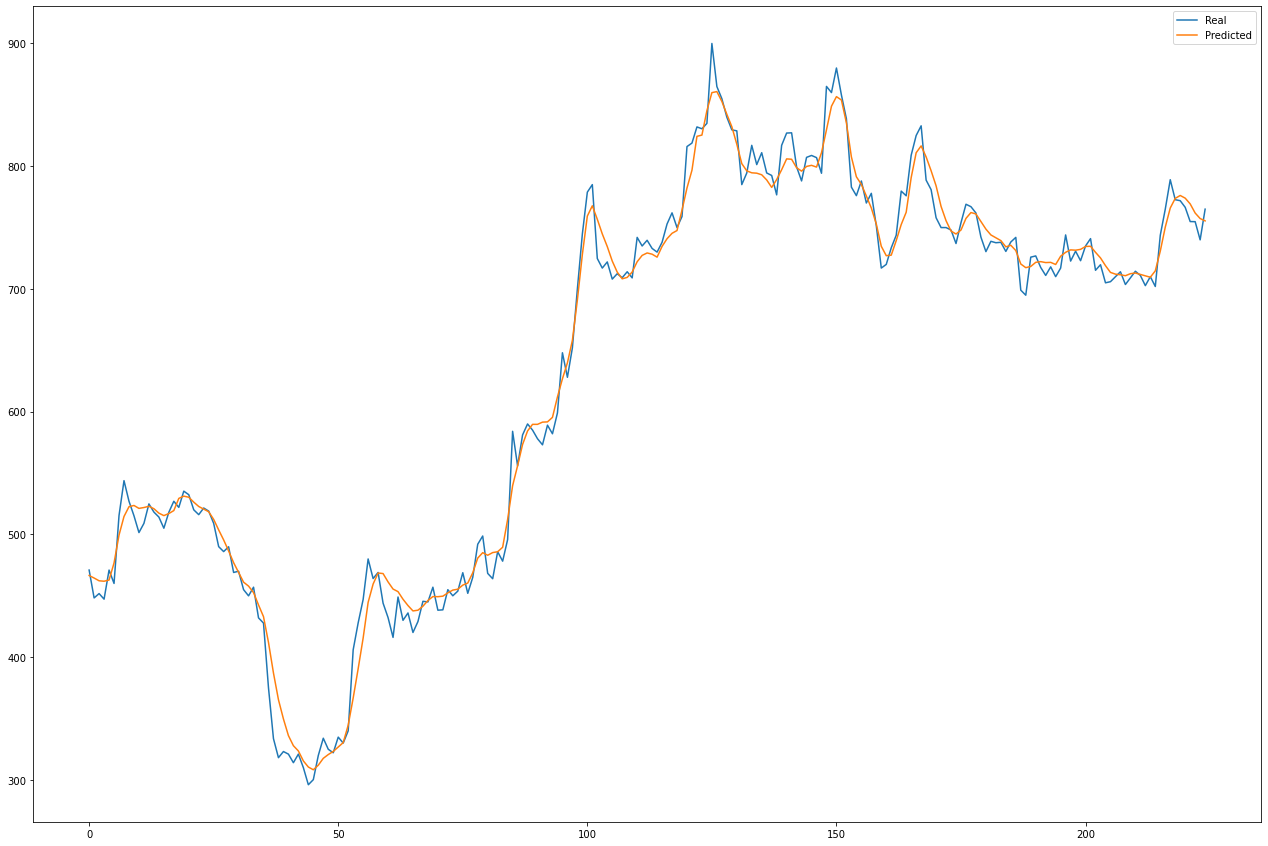

In [30]:
plt.gcf().set_size_inches(22,15, forward = True)

real = plt.plot(unscaled_y_test[start:end], label = 'real')
pred = plt.plot(y_test_predicted[start:end], label = 'predicted')

plt.legend(['Real','Predicted'])

plt.show()

In [31]:
test_set_name = 'dhanuka_daily.csv'

import os
ohlcv_histories = 0
technical_indicators = 0
next_day_open_values = 0

for csv_file_path in list(filter(lambda x : x.endswith('daily.csv'), os.listdir('./'))):
    if not csv_file_path == test_set_name:
        print(csv_file_path)
        if type(ohlcv_histories) == int:
            ohlcv_histories,technical_indicators, next_day_open_values,_,_ = csv_to_dataset(csv_file_path)
        else:
            a,b,c,_,_= csv_to_dataset(csv_file_path)
            ohlcv_histories = np.concatenate((ohlcv_histories,a),0)
            technical_indicators = np.concatenate((technical_indicators,b),0)
            next_day_open_values = np.concatenate((next_day_open_values,c), 0)

ohlcv_train = ohlcv_histories
tech_ind_train = technical_indicators
y_train = next_day_open_values

ohlcv_test,tech_ind_test,y_test,unscaled_y_test,y_scaler = csv_to_dataset(test_set_name)

astec_daily.csv
basf_daily.csv
bayercrop_daily.csv
bharatras_daily.csv
kiriindus_daily.csv
piind_daily.csv
rallis_daily.csv
upl_daily.csv


In [32]:
model.fit(x = [ohlcv_train, tech_ind_train], y = y_train, batch_size = 32, epochs = 50, shuffle = True, validation_split = 0.1)
evaluation = model.evaluate([ohlcv_test, tech_ind_test], y_test)
print(evaluation)

Epoch 1/50
515/515 [==============================] - 16s 31ms/step - loss: 5.0521e-04 - val_loss: 3.5254e-04
Epoch 2/50
515/515 [==============================] - 16s 31ms/step - loss: 4.7135e-04 - val_loss: 3.7539e-04
Epoch 3/50
515/515 [==============================] - 15s 29ms/step - loss: 4.3470e-04 - val_loss: 2.6515e-04
Epoch 4/50
515/515 [==============================] - 16s 32ms/step - loss: 4.4274e-04 - val_loss: 7.5459e-04
Epoch 5/50
515/515 [==============================] - 16s 32ms/step - loss: 4.4387e-04 - val_loss: 2.5609e-04
Epoch 6/50
515/515 [==============================] - 16s 31ms/step - loss: 4.3095e-04 - val_loss: 2.0249e-04
Epoch 7/50
515/515 [==============================] - 15s 30ms/step - loss: 4.1658e-04 - val_loss: 2.8689e-04
Epoch 8/50
515/515 [==============================] - 16s 31ms/step - loss: 4.1021e-04 - val_loss: 2.0603e-04
Epoch 9/50
515/515 [==============================] - 16s 31ms/step - loss: 3.9449e-04 - val_loss: 3.2332e-04
Epoch 10/5

In [33]:
y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict([ohlcv_histories, technical_indicators])
y_predicted = y_normaliser.inverse_transform(y_predicted)
assert unscaled_y_test.shape == y_test_predicted.shape

In [34]:
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse/(np.max(unscaled_y_test) - np.min(unscaled_y_test))*100
print(scaled_mse)

16.41858500631877


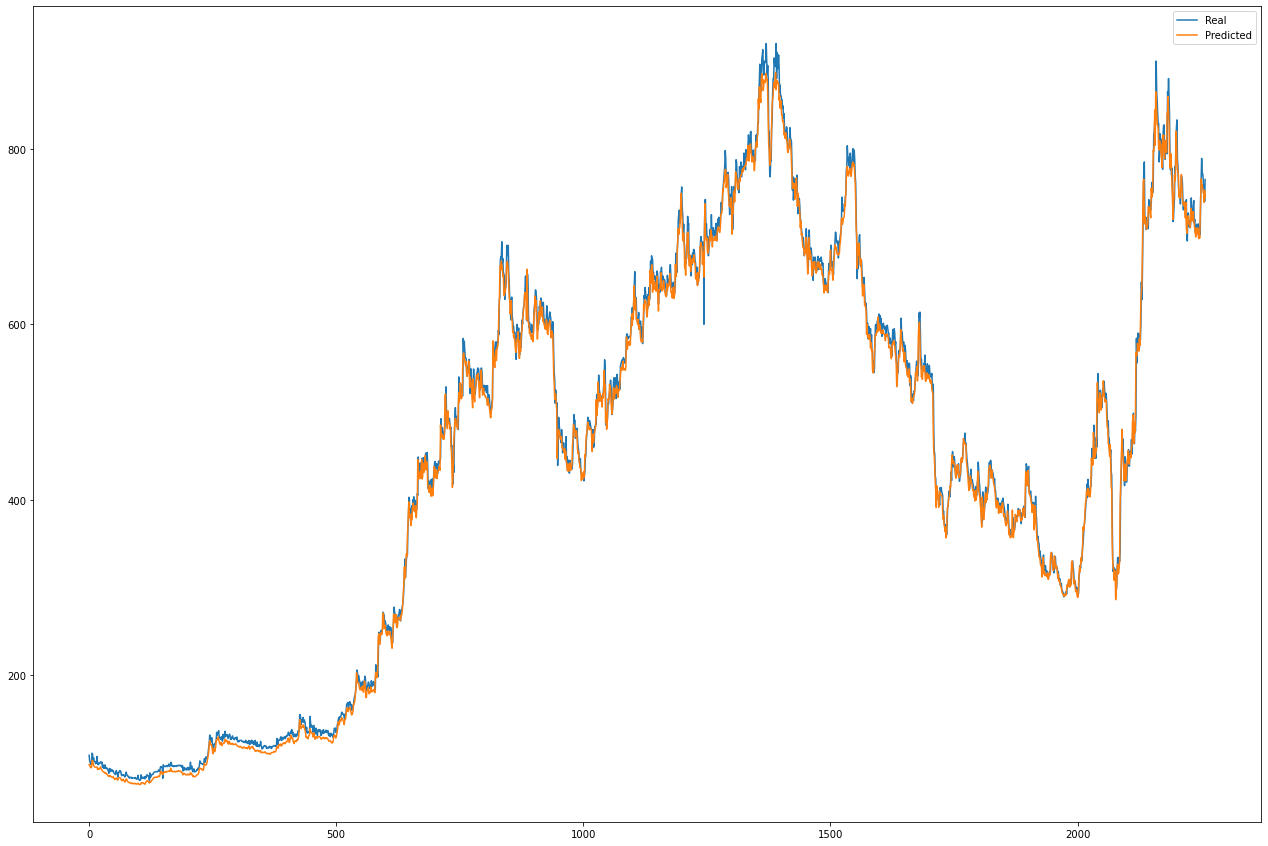

In [35]:
plt.gcf().set_size_inches(22,15, forward = True)

real = plt.plot(unscaled_y_test[start:end], label = 'real')
pred = plt.plot(y_test_predicted[start:end], label = 'predicted')

plt.legend(['Real','Predicted'])

plt.show()

In [36]:
len(unscaled_y_test)

2260

In [37]:
unscaled_y_test

array([[108.85],
       [103.  ],
       [101.3 ],
       ...,
       [740.  ],
       [765.  ],
       [745.7 ]])

In [38]:
y_test_predicted

array([[ 98.277626],
       [ 97.20387 ],
       [ 96.099976],
       ...,
       [752.4824  ],
       [744.1403  ],
       [744.1103  ]], dtype=float32)

In [39]:
len(y_test_predicted)

2260

In [40]:
ohlcv_train.shape

(18277, 84, 5)